# Project-2

This is project-2 which will get you familiar with Structure from Motion and a rudimentary stereo SLAM pipeline. This notebook is not meant for coding, refer to the notebooks in `questions/` for more information.

**Team Name**: `MR21_3241`

**Members**: `2021701032` (Avneesh Mishra), `2019111041` (Prateek Sancheti)

### Submission Instructions:
1. Zip the entire folder, not just this notebook, and submit on Moodle. 
2. Be sure to solve all questions that are in this notebook

This assignment will take around 10-12 hours, so be sure to split the work equally. A recommendation to split the work would be to have one person start with stereo, the other with bundle adjustment, and then both switch to completing the PnP and ICP parts. This is because question-1 and 2 are separate.

## Question 1: Stereo, PnP, and ICP

Time: ~6-7 Hours

This question has been designed to test your understanding of the concepts that create a SLAM system, from creating a front-end using Stereo Matching to a backend where you optimise to get your odometry to stitch the pointclouds obtained from the front end to build a map of the environment.

The dataset has been provided in `data/`, where `img2` and `img3` correspond to the left and right camera images respectively. File `poses.txt` has the pose information for all frames. File `calib.txt` has camera calibration information.

## Question 2: Bundle Adjustment

Time: ~2-3 Hours

This question will walk you through a simple implementation of Bundle Adjustment and run it on a a small dataset. Most of the weightage for this is in the theory part, where you have to explain the method.

## Theory: Part-B Submission

As instructed in the notebook `Bundle Adjustment.ipynb`, the answers to the questions are attached below. The sections contain questions (as they are provided) followed by sections for answers.

### 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.


**Questions**

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics:
    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: 
    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: 

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: 
        
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian:
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: 
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters:        
            
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 6 - Sparsity, Residual Vector & Jacobian: 

### Answers: SfM Pipeline

#### Answer 1

In a practical setting, we will be given the cameras with images, or some identifier associated with images (which could help us find which camera they were taken with). If we're directly given cameras (with say images in the memory) or likewise, the our job is simply a dictionary storage and search (we know the camera each image belongs to).

If we're not given that data, just a set of images from a source like flickr, then we might want to inspect image properties like the user who uploaded it (they likely used the same camera), metadata information, etc. to find the camera a particular image was taken with.

Note that we could also associate images with common camera models (in the worst case).

#### Answer 2

This could be obtained if we have a depth sensor in our setup (which could give us something like a point cloud). Then, if our cameras are calibrated, we can find the projected ray (of a pixel) in 3D space, and run a linear search along that ray to see which point in the point cloud it approximately hits. This will give us the correspondence for 2D (point in image) to 3D (point in real world).

If we do not have a depth sensor, then we may need at least two images of the scene for which we know the focal lengths, and these have a good baseline and rotation. We can then find the corresponding 3D point through triangulation: project the rays of the pixels in the images and see where they meet in 3D space. Note that since we _already_ have a set of 3D points (through our initial estimates), we'll have to associate on something like a nearest neighbor basis.


#### Answer 3

The [Rodrigues' rotation formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) is basically a conversion through a [matrix exponential](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation#Exponential_map_from_%F0%9D%94%B0%F0%9D%94%AC(3)_to_SO(3)) (we get the result directly through taylor expansion). It converts a vector of three numbers (denoted by $\theta\mathbf{\hat{n}}$) into a rotation matrix. We use this property here to transform / rotate the points.

A standard rotation matrix, represented by group $\textup{SO}(3)$ is a 3-by-3 orthogonal matrix. It has 9 elements with 6 constraints (rotations in 3D space have 3 degrees of freedom). This creates a complex manifold, on which we cannot run optimization processes easily. Rotation matrices cannot be simply added, they have to be multiplied (they follow a separate lie algebra).

On the other hand, the exponential representation allows us to have fewer numbers (just 3, which is the minimal). It can also be added to a better degree (unless the addition leads to a singularity). It's manifold is more easier to optimize on, therefore it is used instead.

Another option is to use quaternions, which are 4 number representations and have no singularity issues.

#### Answer 4

Yes. It would make a difference. The correct point is obtained by doing the rotation first, and then translation. Basically, the order of rotation and translation matter. This is because if we translate first, we've basically shifted our origin (we've reached some other place in the world, defined by our _original_ axis, not _rotated_ axis). Now, no rotation can get us to the desired origin (origin defined in the _rotated_ axis, which is the translation vector).

Basically, the homogeneous transform is $\mathbf{p}_{final} = \mathbf{R} \times \mathbf{p} + \mathbf{t}$ and not $\mathbf{p}_{final} = \mathbf{R} \times (\mathbf{p} + \mathbf{t})$. Both these results are two completely different points.

#### Answer 5

In the lecture notes, the number of points is $n$ and the number of cameras is $m$. It is assumed that _every_ point is captured by _every_ camera, yielding us $mn$ pixels (observations). Since each pixel has 2 values (the $x$ and $y$), we got $2mn$ rows for the jacobian (residual will also have the same number of rows).

However, in practice, such an assumption does not hold very well. We might not observe all of the $n$ points in each of the $m$ images. We will only observe a few points of interest in each image (every image will not have some points of interest and may contain some new points of interest). Due to this, the number of rows of the jacobian (or the length of the residual) is actually $2n_{obs}$ (where $n_{obs}$ is the number of observations). The value of $2mn$ is sort of an upper bound.


#### Answer 6

**6.1**: **Individual Motion Jacobian** size is `n_cameras * 9`

It all depends on the way we parameterize the camera projection matrix. In the notes, each camera is assumed to have 5 parameters for the intrinsics (two focal lengths, two center offsets, and one pixel shear), 6 parameters for extrinsics (3 for rotation and 3 for translation). Here, these are reduced to only the focal length and two distortion parameters for intrinsics, while the 6 parameters for the extrinsics remain (3 each for rotation and translation).

Hence, the camera here is parameterized by only 9 numbers, instead of 12. This reduces the size of every individual motion jacobian.

**6.2**: **Number of parameters** for the jacobian

The number of parameters in the notes is $12m+3n$ where $m$ is number of cameras (value of `n_cameras` here) and $n$ is the number of 3D points being estimated (value of `n_points` here). This was because there were 12 parameters for every camera and 3 parameters for every point (that was to be found). Here, the number of parameters for every camera is just 9. Hence, the number of parameters here is $9m+3n$.

The number of variables / parameters by each camera has reduced from 12 to 9. The number of parameters by each 3D point still remains 3.


#### Answer 7

> **Note**: Please do not run the code cells here, run them in the `Bundle Adjustment.ipynb` notebook (in the end). The functions are declared there.

For this example code, the given sample scenario is considered. There are 3 points in the environment (each having its own X, Y, Z). Each of these three points is captured by each of the three cameras in the environment.

The images taken by these cameras will have many pixels (ideally), but for this problem, let's say that we already have an algorithm that detects these points in images (maybe these points could have different colors), and returns those pixel coordinates. So from each image / camera, we get three pixel coordinates (x, y values of pixel in image, could be from the center of image, not the top left corner frame; as is here). So, we have 9 pixels in total (3 pixels from each of 3 cameras). These nine pixels have a pixel to world point correspondence (`point_indices` in the code above) and they also have pixel to camera correspondence (`camera_indices` in the code above). Note that the correspondence here, just says _which_ point or camera (depending on the array) does the particular pixel represent or belong to.

For the code below, the following variable definitions can be noted
- `m_cams`: Number of cameras in the scene. 3 in our case.
- `n_pts`: Number of 3D points in the scene. 3 in our case.
- `pt_is`: The correspondence of the 9 pixels (from the camera images) to the points in the world. Let's assume that our detection and stacking algorithm gave this (in a practical setting).
- `cam_is`: The correspondence of the 9 pixels to the cameras in the world. Since we know which camera took which image, this can be readily obtained.
- `c`: This is the _sparse jacobian matrix_ returned by `bundle_adjustment_sparsity`. The code above described this as `A`.

In [ ]:
m_cams = 3
n_pts = 3
# Points seen (concatenated in image vector, like points_2d)
pt_is = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])   # World points (corr)
# Points taken from camera (correspondence for vector like points_2d)
cam_is = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])  # Camera (corr)
c = bundle_adjustment_sparsity(m_cams, n_pts, cam_is, pt_is)

Let us visualize the Jacobian as an image. Note that only the grid intersection values matter here (kind of how the image can be visualized as a matrix).

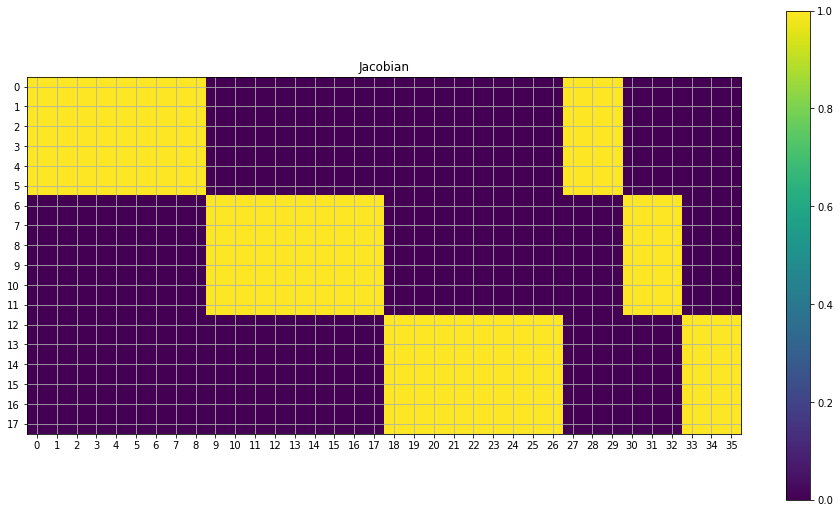

Jacobian shape is: (18, 36)


In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Jacobian")
plt.imshow(c.toarray())
plt.grid(True)
plt.yticks(np.arange(2*m_cams*n_pts))
plt.xticks(np.arange(9*m_cams+3*n_pts))
plt.colorbar()
plt.show()
print(f"Jacobian shape is: {c.shape}")

To compute the residuals (using the function `fun` above), we'll first need our parameter estimates, as well as pixel locations of the points in the image. Let's start with parameter estimates first. We have 9 parameters per camera (3 cameras) and 3 parameters per 3D point (3 points). This parameter vector is stored in `ev`. This is same as `x0` in the code above (initial estimates). However, we'll just use random data here (in a realistic setting, this should be initial estimates).

In [ ]:
# 9 camera parameters of m_cams: camera_params (initial estimate)
cx_params = np.random.rand(9 * m_cams)
# 3 initial estimates of n_pts: points_3d
px_params = np.random.rand(3 * n_pts)
# Parameter vector
ev = np.hstack((cx_params, px_params))

The image too has to be created. We'll simply assume that we have the image pixels and we'll store them in `pix_2d_vect` here. This is similar to the `points_2d` (pixels in 2D) described in code above. Note that we have 3 cameras and each camera gives three pixels (each pixel has 2 values: x, y arranged as columns). Therefore, the first three rows is from camera 1, then from camera 2, then from camera 3. Check the `cam_is` above (camera correspondence).

In [ ]:
# Pixels of the images
pix_2d_vect = np.random.rand(3 * m_cams, 2)

Now, we can compute the residuals (the error in the projection and actual pixels) using the `fun` function. The residuals here is described as `rvect`. In the code above, we passed this (callable function for residuals) to the function [least_squares](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) for optimization.

In [ ]:
# Compute the residuals
rvect = fun(ev, m_cams, n_pts, cam_is, pt_is, pix_2d_vect)
print(f"Residual shape: {rvect.shape}")

Residual shape: (18,)


In [ ]:
# Single stage of Gradient Descent like step
Jc = c.toarray()
d_ev = Jc.T @ rvect  # Change in paraemters
ev_new = ev - (0.01) * d_ev
print(f"Old parameter vector shape: {ev.shape}")
print(f"New parameter vector shape: {ev_new.shape}")

Old parameter vector shape: (36,)
New parameter vector shape: (36,)


This completes a brief step of the optimization process. The non-linear least squares solver used in the code above is _much_ more efficient.

### 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

### Answer: Initial estimates for SfM

The SfM algorithm (or Bundle Adjustment) requires 'good enough' estimates to converse fast and to a good optima. The process is described in the next two cells.

#### R and t estimates for camera

To estimate R, t and the 3D points (as initial estimates), we'll need some way to triangulate them (if we're only given images and the camera intrinsics). Here's briefly how we can go about getting the initial estimates

1. It is assumed that there is an algorithm that has given us the pixel correspondences ([SIFT](https://docs.opencv.org/4.x/d7/d60/classcv_1_1SIFT.html) or some [keypoint detection and matching](https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html) can be used along with some neighborhood estimates or embedding formation).
2. Knowing the corresponding pixels, and given the camera intrinsic parameters we can use 5 point algorithm solvers to estimate the essential matrix. This can be done through the function [findEssentialMat](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad245d60e64d0c1270dbfd0520847bb87). This essential matrix includes the baseline information (vector as skew symmetric cross product matrix) and the rotation matrix.
3. Decompose the essential matrix to obtain the possible translation vector (baseline) and rotation matrices. This uses an SVD technique and is implemented in [decomposeEssentialMat](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga54a2f5b3f8aeaf6c76d4a31dece85d5d). These two steps (2 and 3) can also be done directly, through one function call, using [recoverPose](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1b2f149ee4b033c4dfe539f87338e243). 

This solves our problem of finding the initial estimates of camera poses. That is, we have the initial estimates of the camera parameters given by R, t and we already have the K matrix.


#### Estimates for the 3D points

To find the initial estimates of the 3D points, either of the two methods can be used

1. **Triangulate points** directly: This can be done if we have the camera projection matrices (we already have calibrated cameras / we know the intrinsics). A set of feature points / corresponding pixels can be triangulated (project rays outwards and see where they meet) using the function [triangulatePoints](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad3fc9a0c82b08df034234979960b778c). It takes in the projection matrices of the cameras (given by $P$) and the corresponding points, and returns the 3D points (in homogeneous coordinates). This can then be used to get the euclidean 3D points. This is just a function call, but requires very good correspondence estimates.

2. Find points through **stereo to depth**: Here, we first create the two images into a stereo pair (hopefully there is a good enough baseline). We already know the rotation and translation between the cameras (through the previous steps). 
    1. We can now undistort the images. This can be done by first using [stereoRectify](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6) to get the homographies. The results of this can actually also be used to verify the estimates of R and t for the camera. This function returns the rectification / rotation transform that must be applied to the images. We could directly do $KRK^{-1}$ to the homogeneous coordinates of the pixels. However, using OpenCV would entail two function calls. We can undistort the images (and convert them into _stereo rectified image pairs_) by using [initUndistortRectifyMap](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga7dfb72c9cf9780a347fbe3d1c47e5d5a) (which will give the two output maps) and [remap](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gab75ef31ce5cdfb5c44b6da5f3b908ea4) (which will apply the mapping) in succession for both the images, (as shown in [this](https://python.plainenglish.io/the-depth-i-stereo-calibration-and-rectification-24da7b0fb1e0) tutorial).
        
        On a side-note: In case we do not have calibrated cameras (we don't know the intrinsics), we can use [stereoRectifyUncalibrated](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052) and the resulting output rectification homography matrix can be used to rectify the images into a stereo pair. However, we will need the focal length for reprojection to 3D.
    
    2. After stereo rectification, we can find the disparity map using any of the [stereo matchers](https://docs.opencv.org/4.x/d2/d6e/classcv_1_1StereoMatcher.html). Let's say we pick [StereoBM](https://docs.opencv.org/4.x/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004). We then use [compute](https://docs.opencv.org/4.x/d2/d6e/classcv_1_1StereoMatcher.html#a03f7087df1b2c618462eb98898841345) to obtain the disparity map from the left and right images (that are rectified).
    3. After the disparity map is obtained, we can use [reprojectImageTo3D](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02) to get the 3D point cloud. The function will use an output of stereo rectify that contains information on how to project the points in the undistorted images to 3D (using the disparity). This is shown as $Q$ in the argument list.
    4. Now, we can find the points of interest in this point cloud using search techniques, or scanning along the projected rays of the corresponding pixels.

Using either of the above two methods would give us good enough initial estimates of the 3D points. The latter is actually implemented (steps after stereo rectification) in the `StereoSLAM` notebook.